In this file, both **Random Forest** and **AdaBoost** models are trained and evaluated.

# 1. Random Forest


In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from methods.helper import *
from sklearn.ensemble import AdaBoostClassifier
# Supress all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\mjgoj\miniconda3\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading the binary dataset

In [37]:
lipidomics, metabolomics, proteomics = load_data()
# Load the binary dataset
X_train, X_test, Y_train, y_test = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=2)

First, I will trin the model without any hyperparameter tuning. It will serve as a baseline model.

In [3]:
rf = RandomForestClassifier(
        max_depth=8, class_weight='balanced')
rf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8)

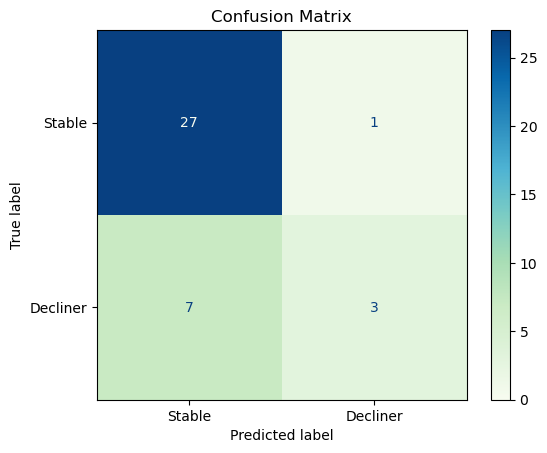

Accuracy of the model: 0.7895
Recall of the model: 0.7895
Precision of the model: 0.7825
Weighted F1 score of the model: 0.7545
Matthews Correlation Coefficient of the model: 0.3792


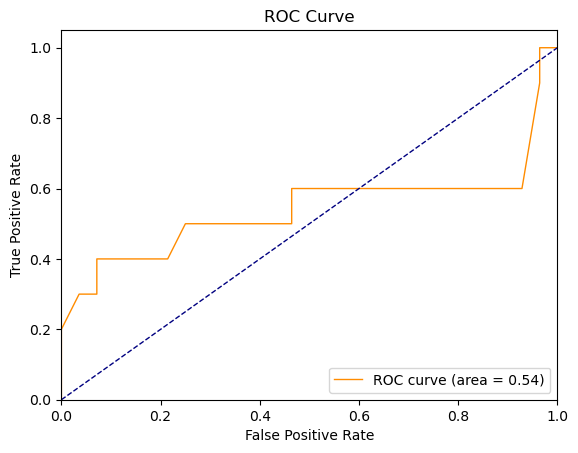

In [4]:
y_pred = rf.predict(X_test)
y_pred_continuous = rf.predict_proba(X_test)[:, 1]
plot_confusion_matrix(y_test, y_pred)
evaluate_model(y_pred, y_test)
plot_ROC_curve(y_pred_continuous, y_test)

### Hyperparameter tuning

Now, I will perform hyperparameter tuning to improve the model's performance.

In [31]:
parameters = {
    'max_depth' : [2, 4, 8, 10, 12, None],
    'n_estimators': [50, 100, 200, 300, 400],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rf = RandomForestClassifier(class_weight='balanced')
grid_search = GridSearchCV(rf, parameters, n_jobs=-1, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 10, 12, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='f1_weighted')

Best parameters:  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


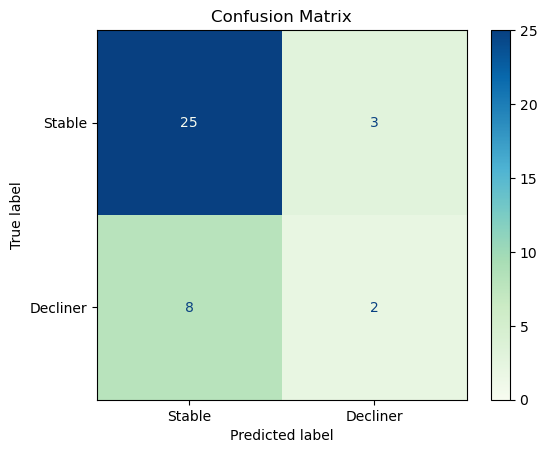

Accuracy of the model: 0.7105
Recall of the model: 0.7105
Precision of the model: 0.6635
Weighted F1 score of the model: 0.6741
Matthews Correlation Coefficient of the model: 0.1210


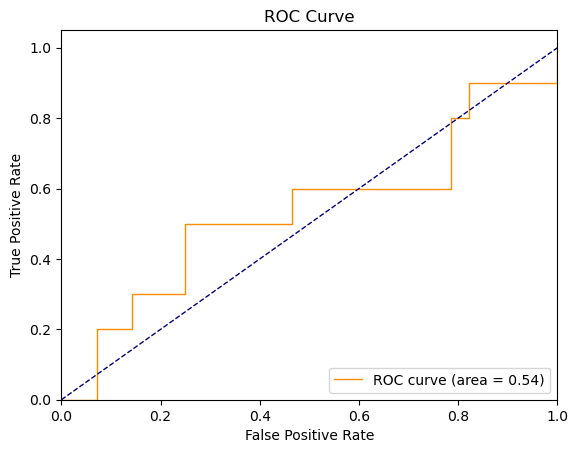

In [32]:
# Evaluation of the model
print("Best parameters: ", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
evaluate_model(y_pred, y_test)
plot_ROC_curve(grid_search.predict_proba(X_test)[:, 1], y_test)

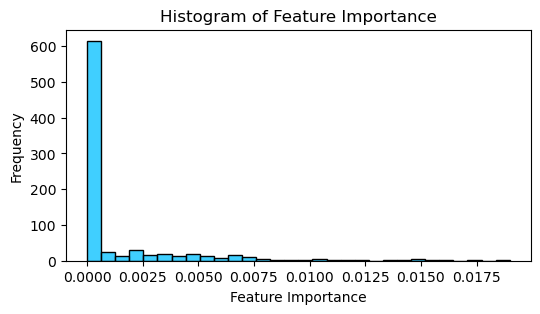

In [33]:
# Plot histogram of feature importance  
plt.figure(figsize=(6, 3))
sns.histplot(
    grid_search.best_estimator_.feature_importances_, 
    bins=30, color='deepskyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Frequency")
plt.title("Histogram of Feature Importance")
plt.show()

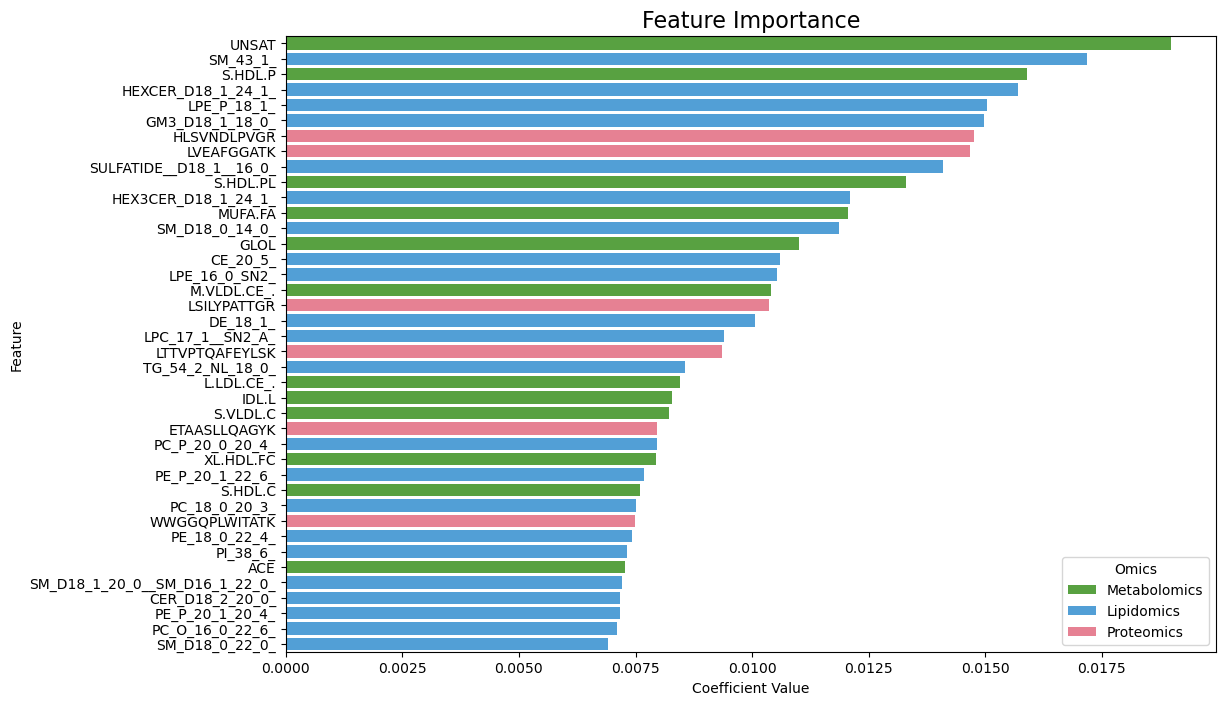

In [35]:
# Plotting feature importance 
plot_feature_importance(
    grid_search.best_estimator_.feature_importances_, X_train.columns, n=40)

### Only Proteomics
Now, I will train the model only on proteomics data so that I can compare the results with the model trained on all data.

First, I will load the train and test split of the proteomics data.

In [38]:
proteomics_train, proteomics_test = get_train_test_split_dataset(proteomics)
# Drop target columns
proteomics_train = proteomics_train.drop(columns=["TwoClass", "RID", "ThreeClass"])
proteomics_test = proteomics_test.drop(columns=["TwoClass", "RID", "ThreeClass"])

Now, I will tune the hyperparameters of the model trained only on proteomics data.

In [39]:
rf = RandomForestClassifier(class_weight='balanced')
grid_search = GridSearchCV(rf, parameters, n_jobs=-1, cv=5, scoring='f1_weighted')
grid_search.fit(proteomics_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 10, 12, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='f1_weighted')

Best parameters:  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


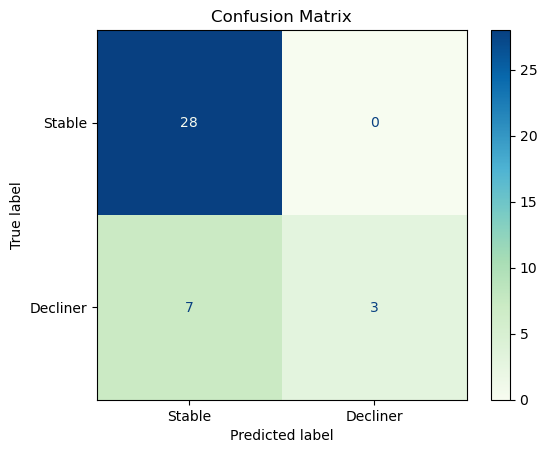

Accuracy of the model: 0.8158
Recall of the model: 0.8158
Precision of the model: 0.8526
Weighted F1 score of the model: 0.7764
Matthews Correlation Coefficient of the model: 0.4899


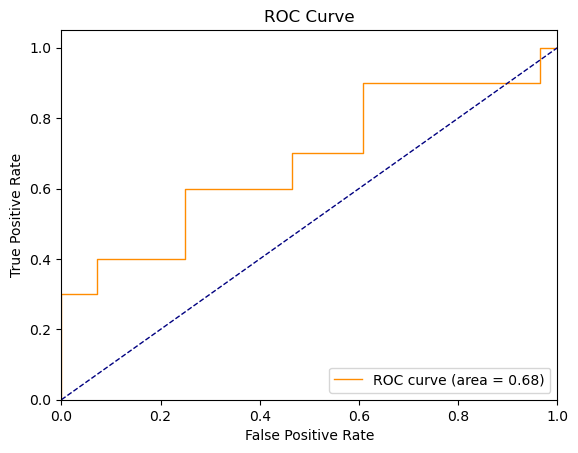

In [41]:
# Evaluation of the model
print("Best parameters: ", grid_search.best_params_)
y_pred = grid_search.predict(proteomics_test)
plot_confusion_matrix(y_test, y_pred)
evaluate_model(y_pred, y_test)
plot_ROC_curve(grid_search.predict_proba(proteomics_test)[:, 1], y_test)

# 2. AdaBoost 

First, I will train the model on the concatenated dataset.

In [12]:
# Creating the AdaBoost Model
ada = AdaBoostClassifier(n_estimators=300, learning_rate=0.01)
ada.fit(X_train, Y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=300)

In [ ]:
y_pred = ada.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
evaluate_model(y_pred, y_test)
plot_ROC_curve(ada.predict_proba(X_test)[:, 1], y_test)

### Hyperparameter tuning

In [26]:
# Hyperparameter tuning
hyperparameters = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5]
}
grid_search = GridSearchCV(
    AdaBoostClassifier(random_state=42), 
    hyperparameters, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, Y_train.values.ravel())

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='f1_weighted')

Best parameters:  {'learning_rate': 0.3, 'n_estimators': 100}


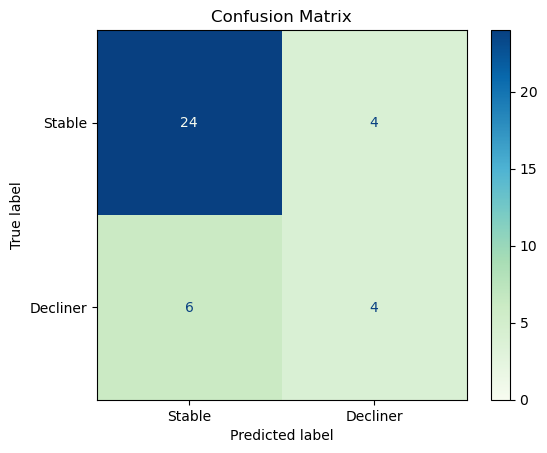

Accuracy of the model: 0.7368
Recall of the model: 0.7368
Precision of the model: 0.7211
Weighted F1 score of the model: 0.7268
Matthews Correlation Coefficient of the model: 0.2777


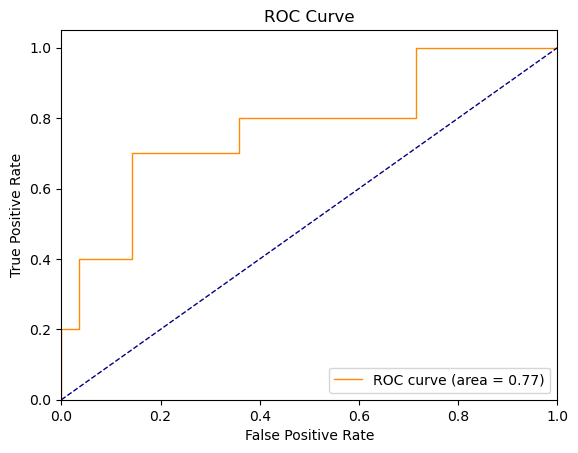

In [27]:
# Evaluation of the model
print("Best parameters: ", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
evaluate_model(y_pred, y_test)
plot_ROC_curve(grid_search.predict_proba(X_test)[:, 1], y_test)

Now, I will train the model only on proteomics data.

In [28]:
grid_search = GridSearchCV(
    AdaBoostClassifier(random_state=42), 
    hyperparameters, cv=5, scoring='f1_weighted')
grid_search.fit(proteomics_train, Y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='f1_weighted')

Best parameters:  {'learning_rate': 0.5, 'n_estimators': 200}


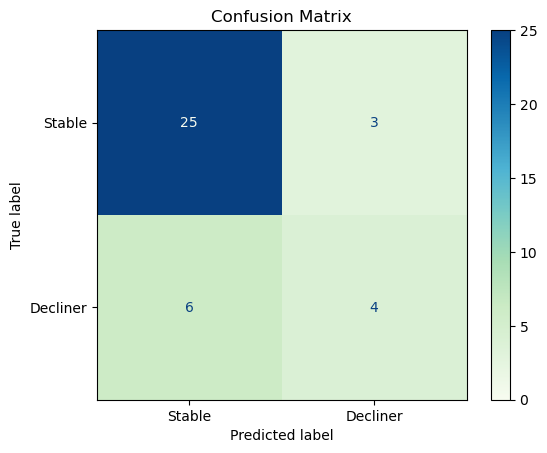

Accuracy of the model: 0.7632
Recall of the model: 0.7632
Precision of the model: 0.7446
Weighted F1 score of the model: 0.7483
Matthews Correlation Coefficient of the model: 0.3327


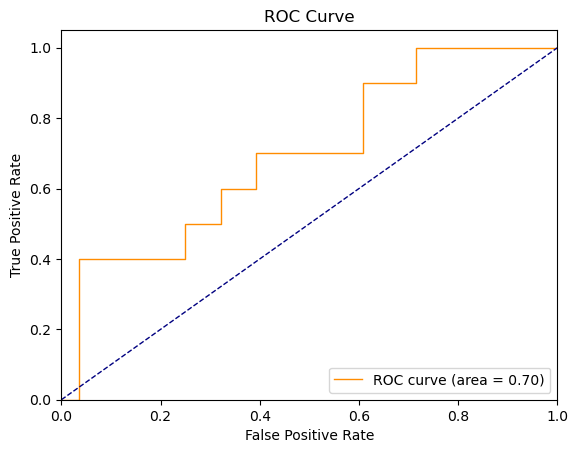

In [30]:
# Evaluation of the model
print("Best parameters: ", grid_search.best_params_)
y_pred = grid_search.predict(proteomics_test)
plot_confusion_matrix(y_test, y_pred)
evaluate_model(y_pred, y_test)
plot_ROC_curve(grid_search.predict_proba(proteomics_test)[:, 1], y_test)